In [1]:
from utils import set_pyplot_params
set_pyplot_params()

Il capitolo introduce il [processo di Poisson](https://en.wikipedia.org/wiki/Poisson_point_process), che è un modello usato per descrivere eventi che accadono a intervalli casuali.

Un esempio di un processo Poisson, modelleremo i goal del calcio. Useremo i goal segnati in una partita per stimare i parametri dei processi di Poisson; poi useremo la distribuzioni a posteriori per fare delle previsioni.

E poi risolveremo il problema della Coppa del Mondo.

## Il problema della Coppa Del Mondo

Nel 2018 nella finale della coppa del mondo FIFA, la Francia battè la Croazia per 4 goal a 2. Basandosi su questo risultato:

1. Quanto dovremmo essere confidenti che la Francia sia la squadra migliore?
2. Se le stesse squadre giocassero ancora, quale è la possibilità che la Francia vinca ancora?

Per rispondere a queste domande, dobbiamo fare alcune decisioni di modellazione.

* Primo, assumeremo che per ogni squadra che si incontra con un'altra squadra ci sia un rapporto di goal sconosciuto, misurato in goal per partita, che denoteremo la variabile python `lam` o la lettera greca $\lambda$, pronunciata "lambda".

* Secondo, assumeremo che un goal e ugualmente probabile durante ogni minuto di gioco, Dunque in una partita di 90 minuti la probabilità di segnare durante il minuto sarà $\lambda/90$.

* Terzo assumeremo che una squadra non segnerà mai due volte nello stesso munito.

Queste assunzioni non sono completamente vere nel mondo reale, ma dovrebbero essere delle semplificazioni ragionabili.
Come disse George Box, "Tutti i modelli sono sbagliti ma alcuni sono utili." (https://en.wikipedia.org/wiki/All_models_are_wrong).

In questo caso il modello è utile in quanto queste assunzioni sono vere almeno approssimativamente. Il numero dei goal nel gioco seguono la distribuzione di Poisson almeno approssimativamente. 

## La distribuzione di Poisson
Se il numero di goal segnati in una partita segue la [distribuzione di Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) con un tasso di goal per partita $\lambda$ la probabilità di segnare $k$ goal è  

$$\lambda^k \exp(-\lambda) ~/~ k!$$

per ogni valore non negativo di $k$.

SciPy fornisce un oggetto `poisson` che rappresenta una distribuzione Poisson.
Ne creiamo una con il parametro $\lambda=1.4$ come questo:

In [2]:
from scipy.stats import poisson

lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

Il risultato è un oggetto che rappresenta la variabile casuale "bloccata" e ci fornisce un oggetto `pmf` che calcola la funzione di probabilità di massa della distribuzione di Poisson.

In [3]:
k = 4
dist.pmf(k)

0.039471954028253146

Questo risultato implica che la media dei gol per partita è di 1.4, la probabilità di segnare 4 gol in una partita è del 4%
Useremo questa funzione per creare un oggetto `Pmf` che rappresenta la distribuzione di Poisson.

In [4]:
import numpy as np
from distribution import Pmf

def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`make_poisson_pmf` prende come parametri il tasso di goal per partita `lam`, e una array di quantità `qs`, che serve per valutare il pmf della distribuzione. Viene poi restituito un oggetto `Pmf`.

Per esempio qui la distribuzione dei goal segnati per `lam=1.4`, calcolata per i valori `k` da 0 a 9.

In [5]:
import numpy as np

lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

In [6]:
from utils import decorate

def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

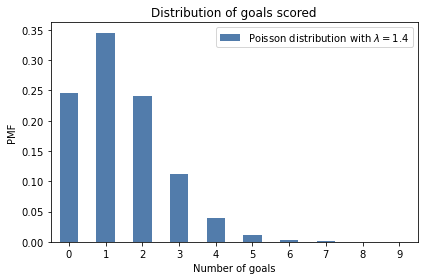

In [7]:
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

decorate_goals('Distribution of goals scored')

I valori più probabili sono 0,1 e 2 valori più alti sono possibili ma sono sempre più improbabili.
Valori sopra 7 sono trascurabili, questa distribuzione mostra che se conosciamo il rapporto dei goal, possiamo fare previsioni sul numero di goal segnati.

Ora giriamo il problema: dato il numero di goal, cosa possiamo dire circa il rapporto dei goal segnati?
Per rispondere a questo, abbiamo bisogno di pensare circa la distribuzione a priori `lam`, che rappresenta la gamma dei possibili valori e delle possibili probabilità prima di vedere il punteggio.

## La distribuzione Gamma

Se hai mai visto una partita di calcio, hai qualche informazioni circa `lam`. Nella maggior parte delle partite le squadre segnano qualche goal ciascuna. In rari casi, le squadre segnano più di 5  goal, ma raramente vengono segnati più di 10 goal.

Usando i dati delle [passate coppe del mondo](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/), Stimiamo che ogni team segna circa 1.4 goal per partita in media. Dunque abbiamo impostato il parametro 
`lam` a 1.4.

Questo valora può cambiare in quanto se giochiamo con una squadra pessima `lam` avrà certamente un valore più alto.Mentre se ci scontriamo con una squadra più forte ci aspettiamo che questo valore sia più basso.

Per modellare la distribuzione del tasso dei goal, useremo la [distribuzione gamma](https://en.wikipedia.org/wiki/Gamma_distribution), l'abbiamo scelta in quanto:

1. Il tasso di goal è continuo e non negativo, la distribuzione gamma è appropriata per questo tipo di quantità.
2. La distribuzione gamma ha solo un parametro, `alpha`, che rappresenta la media. Dunque è facile costruire una distribuzione gamma con la media che vogliamo.
3. Come vedremo, la forma della distribuzione gamma è una scelta ragionabile, dato quello che sappiamo circa il calcio.

C'è anche un motivo in più che vedremo più avanti.

Scipy ci fornisce `gamma`, che crea un oggetto che rappresenta la distribuzione gamma.
Tale oggetto ci da anche la funzione `pdf`, che calcola la **funzione della densità di probabilità** (PDF) della distribuzione gamma.

Qui un esempio.

In [8]:
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

Il parametro,  `alpha`, è la media della distribuzione.
La variabile `qs` rappresenta i possibili valori di `lam` tra 0 e 10.
Mentre `ps` rappresenta la **densità della probabilità** che possiamo pensare come delle probabilità non normalizzate.
Per normalizzarle possiamo mettere questi valori in in oggetto `Pmf` e chiamare la funzione `normalize`:

In [9]:
from distribution import Pmf

prior = Pmf(ps, qs)
prior.normalize()

9.889360237140306

Il risultato è una approssimazione discreta della distribuzione gamma.

In [10]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

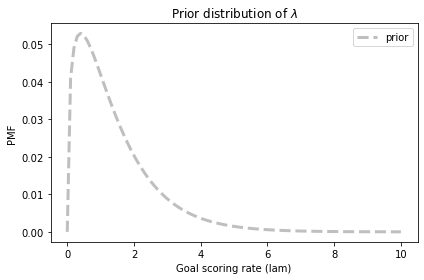

In [11]:
prior.plot(style='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$')

Questa distribuzione rappresenta la nostra conoscenza a priori circa il rapporto 

Questa distribuzione rappresenta la nostra conoscenza a priori circa i goal segnati: `lam` è di solito meno di 2 e occasionalmente più alto di 6 e raramente superiore a quel valore.

In [12]:
prior.mean()

1.4140818156118378

Confermiamo che la media della distribuzione è circa 1.4.

Come al solito, delle persone potrebbero non essere d'accordo circa il dettaglio della distribuzione, ma questo è utile per iniziare. Facciamo un aggiornamento.

## L'aggiornamento

Supponiamo che ti venga dato la rapporto, $\lambda$, ci viene chiesto di calcola la probabilità di segnare un numero di goal, $k$.

Questo è esattamente la domanda a cui abbiamo risposto calcolando il PMF della distribuzione di Poisson.
Per esempio, se $\lambda$ è 1.4, la probabilità di segnare 4 goal in una partita è:

In [13]:
lam = 1.4
k = 4
poisson(lam).pmf(k)

0.039471954028253146

Ora supponiamo che di avere un array di possibili valori di $\lambda$; possiamo calcolare i valori della verosomiglianza dei dati per ogni valore ipotetico di `lam`, come questo:

In [14]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

E questo e quello di cui abbiamo bisogono.
Per ottenere la distribuzione a posteriori, possiamo moltiplicare la distribuzione a priori con la verosomiglianza che abbiamo calcolato e la normalizziamo.

La seguente funzione unisce tutti i passi.

In [15]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

Il primo parametro è la il priori; il secondo è il numero dei goal.
In questo esempio la squadra della Francia ha segnato 4 gol, dunque creeremo una copia della distribuzione a priori e aggiorneremo con i dati.

In [16]:
france = prior.copy()
update_poisson(france, 4)

Qui la distribuzione a posteriori rispetto a quella a priori.

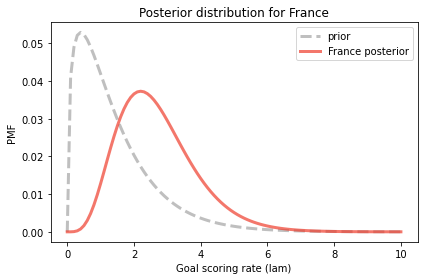

In [17]:
prior.plot(style='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

decorate_rate('Posterior distribution for France')

Il valore `k=4` crea un valore più alto di `lam`, e la distribuzione è spostata verso destra.
Facciamo lo stesso con la croazia:

In [18]:
croatia = prior.copy()
update_poisson(croatia, 2)

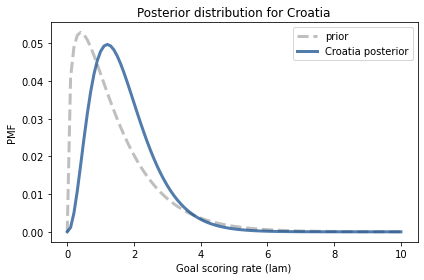

In [19]:
prior.plot(style='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

decorate_rate('Posterior distribution for Croatia')

Qui la media a posteriori delle distribuzioni.

In [20]:
croatia.mean(), france.mean()

(1.6999765866755225, 2.699772393342308)

La media della distribuzione a priori è circa di 1.4.
Dopo che la Croazia ha segnato 2 goal, la media a posteriori è di 1.7, che è vicina al punto centrale della distribuzione di partenza.

Allo stesso modo dopo che la Francia segna 4 goal, la sua media della distribuzione è 2.7.
Questi risultati sono tipici di un aggiornamento Bayesiano, la distribuzione a posteriori è un compromesso tra la distribuzione a priori e i dati.

## La probabilità della superiorità

Ora abbiamo la distribuione a posteriori per ogni team, possiamo rispondere alla prima domanda: Quanto siamo confidenti che la Francia sia la squadra migliore?

In questo modello, "migliore" significa avere un tasso di goal più alto dello sfidante. Possiamo usare le distribuzioni a posteriori per calcolare la probabilità che un valore casuale scelto dalla distribuzione della squarda Francese ecceda i valori della Croazia.

Un modo per falo e quello di iterare tutte le coppie di valori delle due distribuzioni, sommando la probabilità totale che un valore ecceda l'altro.



In [21]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

Questo metodo è molto simile a quanto fatto nelle lezioni precedenti

In [22]:
prob_gt(france, croatia)

0.7499366290930155

`Pmf` ha al suo interno una funzione che fa questo lavoro per noi.

In [23]:
Pmf.gt_dist(france, croatia)

0.7499366290930174

I risultati sono leggermente differenti in quanto `Pmf.gt_dist` usa gli operatori su array piuttosto che il ciclo `for`.
In entrambre i casi, il risultato è vicino al 75%, Dunque, basandosi su questo gioco, possiamo avere una moderata confidenza che la Francia sia attualmente la squadra migliore.

Ovviamente, dobbiamo ricordarci che questo risultato è basato sull'assunto che il tasso di goal sia costante.
In realtà, se una squadra è sotto di un goal, potrebbe giocare in modo più aggressivo verso la fine del gioco, rendendo più probabile che segni ma potrebbero anche più propensi a rinunciare a rinunciare.

Come sempre, i risultati sono buoni solo per il modello.

## Prevedere la rivincita
Ora possiamo rispondere alla seconda domanda: Se le stesse squadre giocassero di nuovo quale è la probabilità che la Croazia possa vincere?.

Per rispondere a questa domanda, potremo generare la "Distribuzione a posteriori predittiva", che è il numero dei goal che ci aspettiamo che un team segni.

Se conosciamo il tasso di goal segnati, `lam`, la distribuzione dei goal potrebbe essere una distribuzione di Poisson con il parametro `lam`.

Dal momento che non conosciamo il valore `lam`, la distribuzione dei goal è una miscela di distribuzioni di Poisson con differenti valori di `lam`.
Per prima cosa generemo una sequenza di `Pmf`, uno per ogni valore di `lam`.

In [24]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs]

La seguente figura mostra come queste distribuzioni appaiono dopo pochi valori di `lam`.

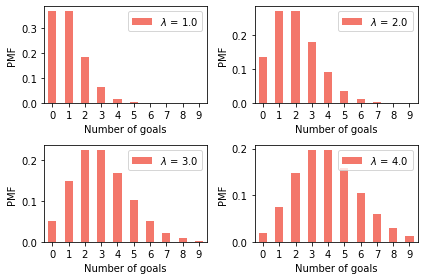

In [25]:
import matplotlib.pyplot as plt

for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    decorate_goals()

La distribuzione predittiva è una miscela di questi oggetti `Pmf`, ponderati con le probabilità a posteriori.

In [26]:
from distribution import make_mixture

pred_france = make_mixture(france, pmf_seq)

Qui la distribuzione predittiva per il numero di goal Francesi che verrebbero segnati in una rivincita.

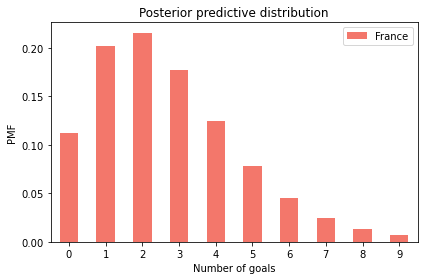

In [27]:
pred_france.bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

Questa distribuzione rappresenta due sorgenti di incertezze: non conosciamo il valore attuale di `lam`, e anche se lo facessimo non conosceremmo il numero di goal segnati nel prossimo gioco.

Qui la distribuzione predittiva della Croazia.

In [28]:
pred_croatia = make_mixture(croatia, pmf_seq)

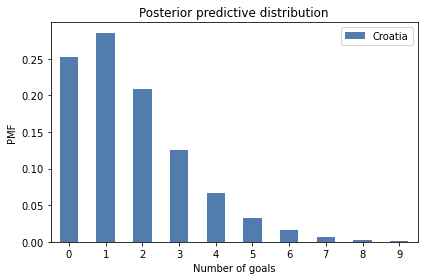

In [29]:
pred_croatia.bar(color='C0', label='Croatia')
decorate_goals('Posterior predictive distribution')

Possiamo usare queste distribuzioni per calcolare la probabilità che la Francia vinca, perda o pareggi lo scontro.

In [30]:
win = Pmf.gt_dist(pred_france, pred_croatia)
win

0.5703522415934519

In [31]:
lose = Pmf.lt_dist(pred_france, pred_croatia)
lose

0.26443376257235873

In [32]:
tie = Pmf.eq_dist(pred_france, pred_croatia)
tie

0.16521399583418947

Assumendo che la Franche vinca metà dei pareggi, le possibilità di vittoria della rivincita è circa del 65%.

In [33]:
win + tie/2

0.6529592395105466

Questa è leggermente inferiore della probabilità di superiorità che è del 75%.
E questo ha senso, in quanto c'è meno certezza circa il risultato di una singola partita che circa il tasso dei gol segnati.
Anche se la Francia è una squadra migliore, potrebbe perdere la partita.

## La distribuzione Esponenziale
Come esercizio alla fine di questo notebook, avremo una possibilità do lavorare alla seguente variante del problema della coppa del mondo:

>Nel 2014 durante la coppa del mondo, La Germania giocò contro il Brasile nelle semifinali. La Germania segno dopo 11 minuti e ancora dopo 23 minuti. A questo punto della partita, quanti goal ci si aspetta che la Germania abbia segnato dopo 90 minuti? Quale è la probabilità che tale squadra segni 5 punti (come alla fine è successo)? 

In questa versione, non siamo interessati al numero di goal in tempo prefissato ma il tempo che passa tra un goal e l'altro.
Per calcolare la verosomiglianza di un dato come questo possiamo sfruttare nuovamente la teoria dei processi di Poisson. Se ogni squadra ha un tasso di goal costande, ci aspettiamo che che i goal vengano segnati con una distanza di tempo che seguono la [distribuzione esponenziale](https://en.wikipedia.org/wiki/Exponential_distribution).

Se il rapporto dei goal segnati è $\lambda$, la probabilità di osservare un intervallo tra i goal $t$ è proporzionale alla PDF della distribuzione esponenziale:

$$\lambda \exp(-\lambda t)$$

Siccome $t$ è una quantità continua, il valor di questa espressione non è una probabilità; è una densità di probabilità.
Comunque è proporzionale alla probabilità del dato, dunque possiamo usare la verosomiglianza in un aggiornamento Bayesiano.

SciPy fornisce la funzione  `expon`, che crea un oggetto che rappresenta la distribuzione esponenziale.
Comunque, questa non usa il parametro `lam` nel modo in cui si aspetterebbe, il che rende difficile lavorarci.
Visto che il PDF di una distribuzione esponenziale è facile da calcolare useremo una nostra funzione.

In [34]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

Per vedere come una distribuzione esponenziale assomigli, assumiamo ancora che il parametro `lam` sia 1.4; possiamo calcolare la distribuzione di $t$ in questo modo:

In [35]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

In [36]:
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

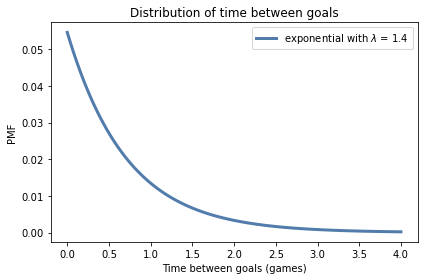

In [37]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')

decorate_time('Distribution of time between goals')

E' controintuitivo ma vero, è molto probabile che il tempo per segnare un goal sia nell'immediato. Dopo questo la probabilità per ogni singolo intervallo è leggermente più piccola.

Con un rapporto di goal di 1.4, è possibile che questa squadra segnerà più di un goal per partita, ma è improbabile che servano più di due partite per segnarli.

## Summario
Questo capitolo introduce tre nuove distribuzioni, dunque potrebbe essere difficile aver capito tutto.
Ripassiamo tutto quanto:

* Se un sistema soddisfa le assunzioni di un modello di Poisson, il numero di eventi in un periodo di tempo segue la distribuzione di Poisson, che è una distribuzione discreta con delle quantità che vanno da 0 a infinito. Nella pratica possiamo di solito ignorare le basse probabilità sopra un certo limite finito.

* Anche sotto il modello di Poisson, l'intervallo tra gli eventi segue una distribuzione esponenziale, che è una distribuzione continua con quantità da 0 a infinito. In quanto continua, essa descrive una funzione di densità di probabilità piuttosto che una funzione PMF. Possiamo usare la distribuzione esponenziale per calcolare la verosomiglianza della verosomiglianza dei dati, possiamo trattare le densita cone delle probabilità non normalizzate. 

* La distribuzione esponenziale e di poisson sono parametrizzati da un tasso di evento $\lambda$ o `lam`.

* Per la distribuzione a priori di $\lambda$, Abbiamo usato una distribuzione gamma, che è una distribuzione continua con quantità tra 0 e infinito, l'abbiamo approssimata con una distribuzione discreta. La distribuzione gamma ha un parametro, denotato $\alpha$ o `alpha` che è anche la sua media.

Abbiamo scelto la distribuzione gamma perchè la sua forma è consistente con la nostra conoscenza di fondo circa il tasso di goal segnati.

Ci sarebbero altre distribuzioni che potrebbero essere usate; comunque in futuro vedremo che la distribuzione gamma.

## Esercizi
**Esercizio:** Finiamo l'esercizio che avevamo iniziato:
>Nel 2014 durante la coppa del mondo, La Germania giocò con il Brasile la partita della semifinale. La Germania segnò dopo 11 minuti e ancora dopo il 23° minuto. A questo punto della partita quanti goal ci aspettiamo che la Germania segni dopo 90 minuti? Quale è la probabilità che vengano segnati più di 5 goal (come nei fatti è successo)? 

Qui i passi raccomandati:
1. Partendo con la stessa distribuzione gamma che abbiamo usato nel precedente problema, calcoliamo la verosomiglianza di segnare un goal dopo 11 minuti per ogni possibile valore di  `lam`. Non dimenticare di convertire tutti i tempi in gioco anzichè in minuti.

2. Calcolare la distribuzione a posteriori di `lam` per la Germania dopo il primo goal.

3. Calcolare la verosomiglianza di segnare un altro goal dopo 12 o più minuti e fare un altro aggiornamento. Visualizzare la distribzione a priori, quella a posteriori dopo due goal. 

4. Calcolare la distribuzione a posteriori predittiva dei goal segnati dalla Germania durante il rimanente tempo di gioco, `90-23` minutes. Nota: puoi pensare come generare i goal predetti in una frazione di gioco.

5. Calcolare la probabilità di segnare 5 o più goal nella fase rimanente di gioco.

In [38]:
# Solution

# Here's a function that updates the distribution of lam
# with the given time between goals

def update_expo(pmf, data):
    """Update based on an observed interval
    
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

In [39]:
# Solution

# Here are the updates for the first and second goals

germany = prior.copy()
update_expo(germany, 11)

germany2 = germany.copy()
update_expo(germany2, 12)

In [40]:
# Solution

# Here are the mean values of `lam` after each update

germany.mean(), germany2.mean()

(2.1358882653086892, 2.703059034926364)

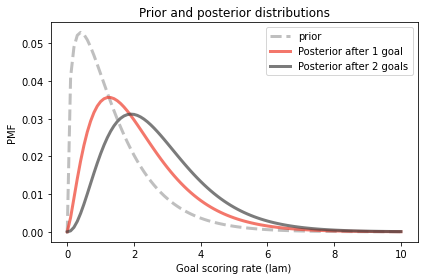

In [41]:
# Solution

# Here's what the posterior distributions look like

prior.plot(ls='--', label='prior', color='C5')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C16', label='Posterior after 2 goals')

decorate_rate('Prior and posterior distributions')

In [42]:
# Solution

# Here's the predictive distribution for each possible value of `lam`

t = (90-23) / 90

pmf_seq = [make_poisson_pmf(lam*t, goals) 
           for lam in germany2.qs]

In [43]:
# Solution

# And here's the mixture of predictive distributions,
# weighted by the probabilities in the posterior distribution.

pred_germany2 = make_mixture(germany2, pmf_seq)

In [44]:
# Solution

# Here's the probability of scoring exactly 5 more goals

pred_germany2[5]

0.047109658706113416

In [47]:
# Solution

# And the probability of 5 or more

pred_germany2.ge_dist(5)

0.09286200122834538